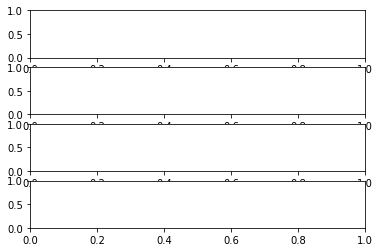

In [28]:
# Room Heating Control (inspired by Lunze 2020) 
import numpy as np
import matplotlib.pyplot as pt
import control as ct
from control.matlab import *
pt.close()
fig, ax = pt.subplots(4,1) # ss, step, rss, dcgain


In [29]:
A = [-0.2] # system matrix
B = [0.2]  # input matrix
C = [5]    # output matrix
D = [0]    # disturbance matrix

In [30]:
# controller parameters
kp = 2.0
Ti = 8.0
Td = 1.0
T  = 0.1
# system parameters
ks = 5.0
y0 = 2.0
x0 = [1 / ks * y0] # initial state
t0, tfin = 0, 50
S = np.linspace(t0, tfin, 100) # sample series

In [31]:
# design system and P|I|D controllers
HeatedRoom = ss(A, B, C, D)

In [32]:
Pblock = tf(kp, 1)        
Iblock = tf(1, [Ti, 0])         
Dblock = tf([Td, 0], [T, 1])
Pctrl   = Pblock
PIctrl  = parallel(Pblock, series(Pblock, Iblock))
PIDctrl = parallel(Pblock,series(Pblock, Iblock),series(Pblock, Dblock))
POpenLoop   = series(Pctrl, HeatedRoom)
PIOpenLoop  = series(PIctrl, HeatedRoom)
PIDOpenLoop = series(PIDctrl, HeatedRoom)

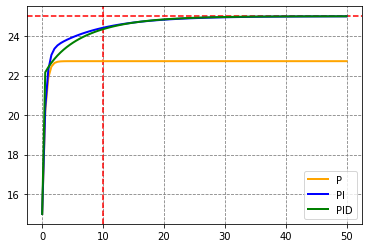

In [33]:
# simulate response to temperature set-point 25 degc
wref = 25
w = wref * np.ones(S.size) # set-point step stimulus
pt.axhline(y=w[0], color='r', linestyle='--')
pt.axvline(x=10, color='r', linestyle='--')
x0 = [3] # initial P state
y, t, x = lsim(feedback(POpenLoop, 1), w, S, x0)
pt.plot(t, y, linewidth=2.0, color='orange', label='P')
x0 = [0,3] # initial Px state
y, t, x = lsim(feedback(PIOpenLoop, 1), w, S, x0)
pt.plot(t, y, linewidth=2.0, color='blue', label='PI')
x0 = [0,0,3] # initial Pxy state
y, t, x = lsim(feedback(PIDOpenLoop, 1), w, S, x0)
pt.plot(t, y, linewidth=2.0, color='green', label='PID')
pt.grid(color='grey', linestyle='--')
pt.legend()
pt.show()

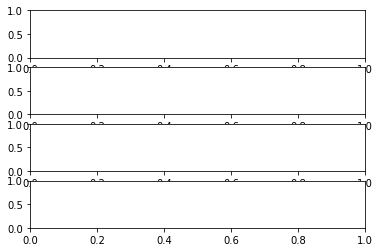

In [34]:
# Exercise: Heated Tanks (inspired by Doyen 2018) 
import numpy as np
import matplotlib.pyplot as pt
import control as ct
from control.matlab import *
pt.close()
fig, ax = pt.subplots(4,1)

In [35]:
################################################################################
# fix model parameters
a1 = a2 = 0.01     # heat transfer to environment
b1 = b2 = 0.005    # heat transfer between tanks
# fix controller parameters
kp1 = kp2 = 0.1     # proportional gain
Ti1 = Ti2 = 1.0    # integral
Td1 = Td2 = 0.0    # derivative
T1  = T2  = 1.0     # derivative delay
# simulation parameters
x0 = [0, 50]       # initial state
t0, tfin = 0, 700  # simulation period

In [36]:
################################################################################
# set up state-space model of the open-loop system
A = [[-a1, b1], [b2, -a2]]
B = [[1, 0], [0, 0]]
C = [[1, 0], [0, 1]] # direct state output
D = [[0, 0], [0, 0]] # no disturbance
modeL1 = ss(A, B, C, D, inputs=['h1', 'h2'], states=['x1', 'x2'], outputs=['x1', 'x2'])

# investigate step response of the open-loop system
y, t = step(modeL1)
ax[0].set(title='Step response (open loop)')
ax[0].plot(t, y[:,0], 'r-', label=r'x$_1$')
ax[0].plot(t, y[:,1], 'b-', label=r'x$_2$')
dcgain(modeL1)

# simulate open-loop system from x0 for a given period and step stimulus
h1 = h2 = 2      
t = np.linspace(t0, tfin, 100)
u = np.transpose([h1*np.ones(t.size), h2*np.ones(t.size)])
y, t, x = lsim(modeL1, u, t, x0)
ax[1].set(title='Simulation (open loop)')
ax[1].plot(t, y[:,0], 'g-', label=r'x$_1$')
ax[1].plot(t, y[:,1], 'b-', label=r'x$_2$')

In [37]:
################################################################################
# design P controllers and closed-loop system
w = np.transpose([70*np.ones(t.size),30*np.ones(t.size)])
P1 = tf(kp1, 1)               
P2 = tf(kp2, 1)  
P = append(P1, P2)      
OpenLoop = series(P, modeL1)
PClosedLoop = feedback(OpenLoop, np.eye(2))
y, t, x = lsim(PClosedLoop, w, t, [0,50])
ax[2].set(title='Simulation (closed loop, with P law)')
ax[2].plot(t, y[:,0], 'g-', label=r'x$_1$')
ax[2].plot(t, y[:,1], 'b-', label=r'x$_2$')

In [38]:
################################################################################
# design LQR controller
Qx = np.diag([10.0, 10.0]) # state weighting matrix
Ru = np.diag([1.0, 1.0]) # input weighting matrix
K, P, E = lqr(A, B, Qx, Ru) # obtain LQR law u=-K*x
LQRClosedLoop = ss(A-B*K,B*K,C,D)
y, t,x = lsim(LQRClosedLoop, w, t, x0)
ax[3].set(title='Simulation (closed loop with MIMO/coupled LQR law)')
ax[3].plot(t, y[:,0], 'g-', label=r'x$_1$')
ax[3].plot(t, y[:,1], 'b-', label=r'x$_2$')

# decorate and show all plots
for a in ax:
    a.set(xlabel='Time (s)', ylabel=r'Temperatures (\textdegree C)', xlim=(0,tfin))
    a.grid(color='lightgray', linestyle='--')
    a.legend()
fig.show()

/tmp/ipykernel_3310/3914518563.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Rank 2
EigResult(eigenvalues=array([10., 10.]), eigenvectors=array([[1., 0.],
       [0., 1.]]))


/tmp/ipykernel_3310/186648887.py:45: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


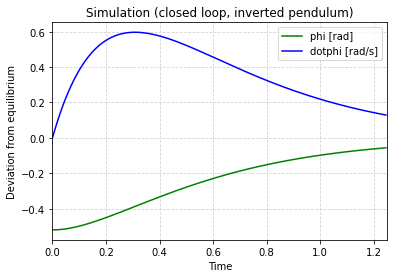

In [53]:
#!/usr/bin/python
# Exercise: LQ Optimal Control (inspired by Lunze 2020, Lin 2022) 
import numpy as np
import matplotlib.pyplot as pt
import control as ct
from control.matlab import * 
pt.close()
fig, ax = pt.subplots(1,1)

# inverted pendulum parameters
g = 9.81 # m/s^2
l = 3*g/(2*21.5)
m = 3/(0.6*l**2)
# state-space model of the *linearised* inverted pendulum
A = [[0, 1], [(3*g)/2*l, 0]]
B = [[0], [3/(m*l**2)]]
C = [[1, 0],
     [0, 1]]
D = [[0],[0]]

# optimisation parameters
dt = 0.005 # precision
tf = 1.25 # time span
t = np.arange(0,tf,dt) # sampling points
Q = np.diag([10.0, 10.0])
R = np.diag([1.0])
x0 = [[-.52], [0]] # initial state [rad, rad/s]

# build open-loop model of the inverted pendulum
InvPendSimple = ss(A, B, C, D, states=['$\phi$', '$\dot\phi$'], inputs=['u'], outputs=['$\phi$', '$\dot\phi$'])

# find optimal (LQ) controller
xe =  np.array([[0], [0]])
print("Rank", np.linalg.matrix_rank(ct.ctrb(A, B))) # controllable?
print(np.linalg.eig(Q)) # definiteness (all eigenvalues real pos/neg)
K, P, E = lqr(A, B, Q, R); # solve Riccati DE and get optimal controller
LQRClosedLoop = ss(A-B*K,B*K*xe,C,[[0,0],[0,0]])
y, t, x = lsim(LQRClosedLoop, np.zeros([250,2]), t, x0) # simulate
ax.set(title='Simulation (closed loop, inverted pendulum)')
ax.plot(t, y[:,0], 'g-', label='phi [rad]')
ax.plot(t, y[:,1], 'b-', label='dotphi [rad/s]')
ax.set(xlabel='Time', ylabel='Deviation from equilibrium', xlim=(0,tf))
ax.grid(color='lightgray', linestyle='--')
ax.legend()
fig.show()